In [1]:
import numpy as np
import pandas as pd
import random
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [2]:
df = pd.read_feather('../../dataset/preprocessed_data.feather')[['event_type', 'product_id', 'category_id', 'category_code', 'brand', 'user_id']]
df.head()

,event_type,product_id,category_id,category_code,brand,user_id
0,view,44600062,2103807459595387724,#unknown,shiseido,541312140
1,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,554748717
2,view,17200506,2053013559792632471,furniture.living_room.sofa,#unknown,519107250
3,view,1307067,2053013558920217191,computers.notebook,lenovo,550050854
4,view,1004237,2053013555631882655,electronics.smartphone,apple,535871217


In [3]:
total_rows = len(df)

train_size = int(total_rows * 0.9)

train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

print(f'train: {len(train_df)}, test: {len(test_df)}')

del df

train: 38203885, test: 4244877


In [4]:
user_counts = train_df['user_id'].value_counts().reset_index()[['user_id', 'count']]
unique_user_ids = user_counts[user_counts['count'] >= 10]['user_id']
user_id_to_index = {user_id: index for index, user_id in enumerate(unique_user_ids)}
user_index_to_id = {index: user_id for index, user_id in enumerate(unique_user_ids)}

product_counts = train_df['product_id'].value_counts().reset_index()[['product_id', 'count']]
unique_product_ids = product_counts[product_counts['count'] >= 10]['product_id']
product_id_to_index = {product_id: index for index, product_id in enumerate(unique_product_ids)}
product_index_to_id = {index: product_id for index, product_id in enumerate(unique_product_ids)}

del user_counts, product_counts

In [5]:
unique_brands = train_df['brand'].unique()
brand_id_to_index = {brand: index for index, brand in enumerate(unique_brands)}
brand_index_to_id = {index: brand for index, brand in enumerate(unique_brands)}

unique_category_ids = train_df['category_id'].unique()
category_id_to_index = {category_id: index for index, category_id in enumerate(unique_category_ids)}
category_index_to_id = {index: category_id for index, category_id in enumerate(unique_category_ids)}

In [6]:
train_df = train_df[
    (train_df['user_id'].isin(unique_user_ids)) & 
    (train_df['product_id'].isin(unique_product_ids)) &
    (train_df['brand'].isin(unique_brands)) &
    (train_df['category_id'].isin(unique_category_ids))
]

test_df = test_df[
    (test_df['user_id'].isin(unique_user_ids)) & 
    (test_df['product_id'].isin(unique_product_ids)) &
    (test_df['brand'].isin(unique_brands)) &
    (test_df['category_id'].isin(unique_category_ids))
]

train_df['user_index'] = [user_id_to_index[user_id] for user_id in train_df['user_id']]
train_df['product_index'] = [product_id_to_index[product_id] for product_id in train_df['product_id']]
train_df['brand_index'] = [brand_id_to_index[brand] for brand in train_df['brand']]
train_df['category_index'] = [category_id_to_index[category_id] for category_id in train_df['category_id']]

test_df['user_index'] = [user_id_to_index[user_id] for user_id in test_df['user_id']]
test_df['product_index'] = [product_id_to_index[product_id] for product_id in test_df['product_id']]
test_df['brand_index'] = [brand_id_to_index[brand] for brand in test_df['brand']]
test_df['category_index'] = [category_id_to_index[category_id] for category_id in test_df['category_id']]

print(f'unique user ids: {len(unique_user_ids)}')
print(f'unique product ids: {len(unique_product_ids)}')
print(f'unique brands: {len(unique_brands)}')
print(f'unique category ids: {len(unique_category_ids)}')
print(f'train: {len(train_df)}, test: {len(test_df)}')

train_df.head()

unique user ids: 890624
unique product ids: 111230
unique brands: 3299
unique category ids: 613
train: 31907671, test: 2237434


,event_type,product_id,category_id,category_code,brand,user_id,user_index,product_index,brand_index,category_index
0,view,44600062,2103807459595387724,#unknown,shiseido,541312140,32147,28939,0,0
2,view,17200506,2053013559792632471,furniture.living_room.sofa,#unknown,519107250,462789,5410,2,2
3,view,1307067,2053013558920217191,computers.notebook,lenovo,550050854,427246,213,3,3
4,view,1004237,2053013555631882655,electronics.smartphone,apple,535871217,84837,43,4,4
5,view,1480613,2053013561092866779,computers.desktop,pulser,512742880,140152,11240,5,5


In [7]:
class FMDataset(Dataset):
    def __init__(self, df):
        self.data = []
        for user, product, brand, category in df[['user_index', 'product_index', 'brand_index', 'category_index']].values:
            self.data.append([int(user), int(product), int(brand), int(category)])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

train_dataset = FMDataset(train_df)
test_dataset = FMDataset(test_df)

In [8]:
print(f'train:{len(train_dataset)}, test: {len(test_dataset)}')
print(train_dataset[0])
print(test_dataset[0])

train:31907671, test: 2237434
[32147, 28939, 0, 0]
[183080, 363, 53, 4]


In [9]:
# For negative sampling
user_index_to_viewed_product_indices = train_df.groupby('user_index')['product_index'].agg(set).to_dict()
product_index_to_brand_index = dict(zip(train_df['product_index'], train_df['brand_index']))
product_index_to_category_index = dict(zip(train_df['product_index'], train_df['category_index']))
total_product_indices = train_df['product_index'].tolist()

In [10]:
def collate_fn(batch):
    users = []
    products = []
    brands = []
    categories = []

    neg_users = []
    neg_products = []
    neg_brands = []
    neg_categories = []
    
    for row in batch:
        user = row[0]
        product = row[1]
        brand = row[2]
        category = row[3]

        user_viewed_product_indices = user_index_to_viewed_product_indices.get(user, [])
        negative_product = None
        while True:
            negative_product = random.choice(total_product_indices)
            if negative_product not in user_viewed_product_indices:
                break

        negative_brand = product_index_to_brand_index[negative_product]
        negative_category = product_index_to_category_index[negative_product]

        users.append(user)
        products.append(product)
        brands.append(brand)
        categories.append(category)

        neg_users.append(user)
        neg_products.append(negative_product)
        neg_brands.append(negative_brand)
        neg_categories.append(negative_category)

    pos_inputs = []
    for user, product, brand, category in zip(users, products, brands, categories):
        pos_inputs.append(([user, product, brand, category]))

    neg_inputs = []
    for user, product, brand, category in zip(neg_users, neg_products, neg_brands, neg_categories):
        neg_inputs.append(([user, product, brand, category]))
    
    return torch.LongTensor(pos_inputs), torch.LongTensor(neg_inputs)

In [11]:
batch_size = 4096
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

print(f'train: {len(train_loader)}, test: {len(test_loader)}')

train: 7790, test: 547


In [12]:
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
print(f'device: {device}')

device: mps


In [13]:
class FeatureLinear(nn.Module):
    def __init__(self, field_dims):
        super(FeatureLinear, self).__init__()
        self.fc = nn.Embedding(sum(field_dims), 1)
        self.bias = nn.Parameter(torch.zeros((1,)))
        self.offsets = np.array((0, *np.cumsum(field_dims)[:-1]), dtype=np.long)
    
    def forward(self, x):
        x = x + x.new_tensor(self.offsets).unsqueeze(0)
        return torch.sum(self.fc(x), dim=1) + self.bias


class FeatureEmbedding(nn.Module):
    def __init__(self, field_dims, embedding_dim):
        super(FeatureEmbedding, self).__init__()
        self.embedding = nn.Embedding(sum(field_dims), embedding_dim)
        self.offsets = np.array((0, *np.cumsum(field_dims)[:-1]), dtype=np.long)
        nn.init.xavier_uniform_(self.embedding.weight.data)

    def forward(self, x):
        x = x + x.new_tensor(self.offsets).unsqueeze(0)
        return self.embedding(x)


class FM(nn.Module):
    def __init__(self):
        super(FM, self).__init__()

    def forward(self, x):
        ix = 0.5 * ((torch.sum(x, dim=1) ** 2) - (torch.sum(x ** 2, dim=1))).sum(dim=1, keepdim=True)
        return ix

class MLP(nn.Module):
    def __init__(self, input_dim, embedding_dims, dropout):
        super(MLP, self).__init__()
        layers = []
        for embedding_dim in embedding_dims:
            layers.append(nn.Linear(input_dim, embedding_dim))
            layers.append(nn.BatchNorm1d(embedding_dim))
            layers.append(nn.ReLU())
            if dropout:
                layers.append(nn.Dropout(p=dropout))
            input_dim = embedding_dim
        layers.append(nn.Linear(input_dim, 1))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

        
class DeepFM(nn.Module):
    def __init__(self, field_dims, embedding_dim, mlp_dims, dropout):
        super(DeepFM, self).__init__()
        self.linear = FeatureLinear(field_dims)
        self.fm = FM()
        self.embedding = FeatureEmbedding(field_dims, embedding_dim)
        self.embedding_output_dim = len(field_dims) * embedding_dim
        self.mlp = MLP(self.embedding_output_dim, mlp_dims, dropout)

    def forward(self, x):
        embed_x = self.embedding(x)
        out = self.linear(x) + self.fm(embed_x) + self.mlp(embed_x.view(-1, self.embedding_output_dim))
        return out.squeeze()

class BPRLoss(nn.Module):
    def __init__(self):
        super(BPRLoss, self).__init__()
        self.sigmoid = nn.Sigmoid()

    def forward(self, positive, negative):
        distances = positive - negative
        loss = -torch.sum(torch.log(self.sigmoid(distances)))
        return loss

In [14]:
def create_model():
    return DeepFM(
         field_dims=[len(unique_user_ids), len(unique_product_ids), len(unique_brands), len(unique_category_ids)],
         embedding_dim=8,
         mlp_dims=[16],
         dropout=0.3,
    ).to(device)

model = create_model()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)
criterion = BPRLoss()

In [15]:
def train(model, optimizer, criterion, dataloader):
    model.train()
    total_loss = 0
    total = 0

    for pos_inputs, neg_inputs in tqdm(dataloader, desc="Train"):
        pos_outputs = model(pos_inputs.to(device))
        neg_outputs = model(neg_inputs.to(device))
        loss = criterion(pos_outputs, neg_outputs)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total += pos_inputs.size(0)

    avg_loss = total_loss / len(dataloader)
    return avg_loss

def evaluate(model, criterion, dataloader):
    model.eval()
    total_loss = 0
    total = 0

    with torch.no_grad():
        for pos_inputs, neg_inputs in tqdm(dataloader, desc="Eval"):
            pos_outputs = model(pos_inputs.to(device))
            neg_outputs = model(neg_inputs.to(device))
            loss = criterion(pos_outputs, neg_outputs)

            total_loss += loss.item()
            total += pos_inputs.size(0)

    avg_loss = total_loss / len(dataloader)
    return avg_loss

In [16]:
patience = 3
best_loss = float('inf')
counter = 0

n_epochs = 50
for epoch in range(n_epochs):
    train_loss = train(model, optimizer, criterion, train_loader)
    eval_loss = evaluate(model, criterion, test_loader)

    print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Eval Loss: {eval_loss:.4f}')

    if eval_loss < best_loss:
        best_loss = eval_loss
        counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break

Eval: 100%|██████████| 547/547 [00:07<00:00, 75.93it/s]


Epoch 1, Train Loss: 3314.9956, Eval Loss: 2802.8634


Eval: 100%|██████████| 547/547 [00:10<00:00, 50.28it/s]


Epoch 2, Train Loss: 2788.6312, Eval Loss: 2607.5321


Eval: 100%|██████████| 547/547 [00:07<00:00, 75.84it/s]


Epoch 3, Train Loss: 2518.2387, Eval Loss: 2434.5771


Eval: 100%|██████████| 547/547 [00:07<00:00, 75.22it/s]


Epoch 4, Train Loss: 2290.8123, Eval Loss: 2339.0276


Eval: 100%|██████████| 547/547 [00:07<00:00, 74.10it/s]


Epoch 5, Train Loss: 2101.4234, Eval Loss: 2275.0475


Eval: 100%|██████████| 547/547 [00:11<00:00, 47.98it/s]


Epoch 6, Train Loss: 1939.1666, Eval Loss: 2221.3082


Eval: 100%|██████████| 547/547 [00:07<00:00, 74.69it/s]


Epoch 7, Train Loss: 1787.7975, Eval Loss: 2172.6466


Eval: 100%|██████████| 547/547 [00:07<00:00, 74.22it/s]


Epoch 8, Train Loss: 1646.9454, Eval Loss: 2137.5036


Eval: 100%|██████████| 547/547 [00:07<00:00, 72.44it/s]


Epoch 9, Train Loss: 1521.4307, Eval Loss: 2119.4046


Eval: 100%|██████████| 547/547 [00:11<00:00, 46.33it/s]


Epoch 10, Train Loss: 1414.4896, Eval Loss: 2111.4788


Eval: 100%|██████████| 547/547 [00:07<00:00, 74.47it/s]


Epoch 11, Train Loss: 1324.2753, Eval Loss: 2112.4727


Eval: 100%|██████████| 547/547 [00:07<00:00, 73.70it/s]


Epoch 12, Train Loss: 1246.3490, Eval Loss: 2101.7004


Eval: 100%|██████████| 547/547 [00:07<00:00, 74.91it/s]


Epoch 13, Train Loss: 1180.0849, Eval Loss: 2111.9749


Eval: 100%|██████████| 547/547 [00:12<00:00, 45.02it/s]


Epoch 14, Train Loss: 1120.9875, Eval Loss: 2119.3108


Eval: 100%|██████████| 547/547 [00:07<00:00, 73.83it/s]

Epoch 15, Train Loss: 1068.9652, Eval Loss: 2123.8472
Early stopping triggered at epoch 15


In [17]:
model = create_model()
model.load_state_dict(torch.load('best_model.pth'))

/var/folders/61/z_y23ln573b2r1g8y664sldc0000gn/T/ipykernel_83875/2981501294.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.

<All keys matched successfully>

In [18]:
def recommend_all(n_sample_users=10000):
    sample_user_indicies = test_df['user_index'].unique().tolist()[:n_sample_users]
    product_indices = train_df['product_index'].unique().tolist()
    brand_indices = [product_index_to_brand_index[i] for i in product_indices]
    category_indices = [product_index_to_category_index[i] for i in product_indices]

    recommend_dict = {}
    for user in tqdm(sample_user_indicies):
        inputs = []
        for product, brand, category in zip(product_indices, brand_indices, category_indices):
            inputs.append([user, product, brand, category])

        scores = []
        for i in range(0, len(inputs), 16384):
            batch_inputs = inputs[i: i + 16384]
            batch_inputs = torch.LongTensor(batch_inputs).to(device)
            with torch.no_grad():
                batch_scores = model(batch_inputs).squeeze()
            scores.append(batch_scores)

        scores = torch.cat(scores)

        _, top_indices = torch.topk(scores, 500)
        recommend_product_indices = [product_indices[i] for i in top_indices]
        recommend_product_ids = [product_index_to_id[i] for i in recommend_product_indices]
        user_id = user_index_to_id[user]
        recommend_dict[user_id] = recommend_product_ids

    return recommend_dict

recommendations_dict = recommend_all()

100%|██████████| 10000/10000 [32:47<00:00,  5.08it/s] 


In [19]:
interaction_dict = test_df.groupby('user_id')['product_id'].agg(lambda x: list(set(x))).to_dict()

In [20]:
def calculate_metrics(topk=10):

    total_users = 0
    precision_sum = 0
    recall_sum = 0
    ndcg_sum = 0

    for user_id in tqdm(interaction_dict.keys()):
        if user_id not in recommendations_dict:
            continue

        true_items = set(interaction_dict[user_id])
        recommended_items = recommendations_dict[user_id]
        top_k_items = set(recommended_items[:topk])

        # precision
        precision = len(top_k_items & true_items) / len(recommended_items)
        precision_sum += precision
        
        # recall
        recall = len(top_k_items & true_items) / len(true_items)
        recall_sum += recall

        # NDCG
        dcg = 0
        idcg = 0
        for i, item in enumerate(top_k_items):
            rel = 1 if item in true_items else 0
            dcg += (2**rel - 1) / np.log2(i + 2)
        
        ideal_ranking = sorted([1 if item in true_items else 0 for item in top_k_items], reverse=True)
        for i, rel in enumerate(ideal_ranking):
            idcg += (2**rel - 1) / np.log2(i + 2)
        
        ndcg = dcg / idcg if idcg > 0 else 0
        ndcg_sum += ndcg

        total_users += 1
        
    mean_precision = precision_sum / total_users
    mean_recall = recall_sum / total_users
    mean_ndcg = float(ndcg_sum / total_users)

    return mean_precision, mean_recall, mean_ndcg

In [21]:
topk_values = [10, 30, 50, 100, 200, 300, 400, 500]

precisions, recalls, ndcgs = [], [], []
for topk in topk_values:
    precision, recall, ndcg = calculate_metrics(topk=topk)
    precisions.append(precision)
    recalls.append(recall)
    ndcgs.append(ndcg)
    print(f'precision@{topk}: {precision:.5f}, recall@{topk}: {recall:.5f}, ndcg@{topk}: {ndcg:.5f}')

100%|██████████| 201351/201351 [00:00<00:00, 923603.46it/s]


precision@10: 0.00002, recall@10: 0.00164, ndcg@10: 0.00510


100%|██████████| 201351/201351 [00:00<00:00, 390074.33it/s]


precision@30: 0.00005, recall@30: 0.00304, ndcg@30: 0.00748


100%|██████████| 201351/201351 [00:00<00:00, 257270.53it/s]


precision@50: 0.00007, recall@50: 0.00389, ndcg@50: 0.00824


100%|██████████| 201351/201351 [00:01<00:00, 130429.89it/s]


precision@100: 0.00011, recall@100: 0.00640, ndcg@100: 0.01038


100%|██████████| 201351/201351 [00:02<00:00, 67821.60it/s]


precision@200: 0.00018, recall@200: 0.01118, ndcg@200: 0.01377


100%|██████████| 201351/201351 [00:04<00:00, 44785.13it/s]


precision@300: 0.00023, recall@300: 0.01383, ndcg@300: 0.01513


100%|██████████| 201351/201351 [00:06<00:00, 33505.16it/s]


precision@400: 0.00026, recall@400: 0.01618, ndcg@400: 0.01421


100%|██████████| 201351/201351 [00:07<00:00, 26704.84it/s]

precision@500: 0.00029, recall@500: 0.01802, ndcg@500: 0.01483


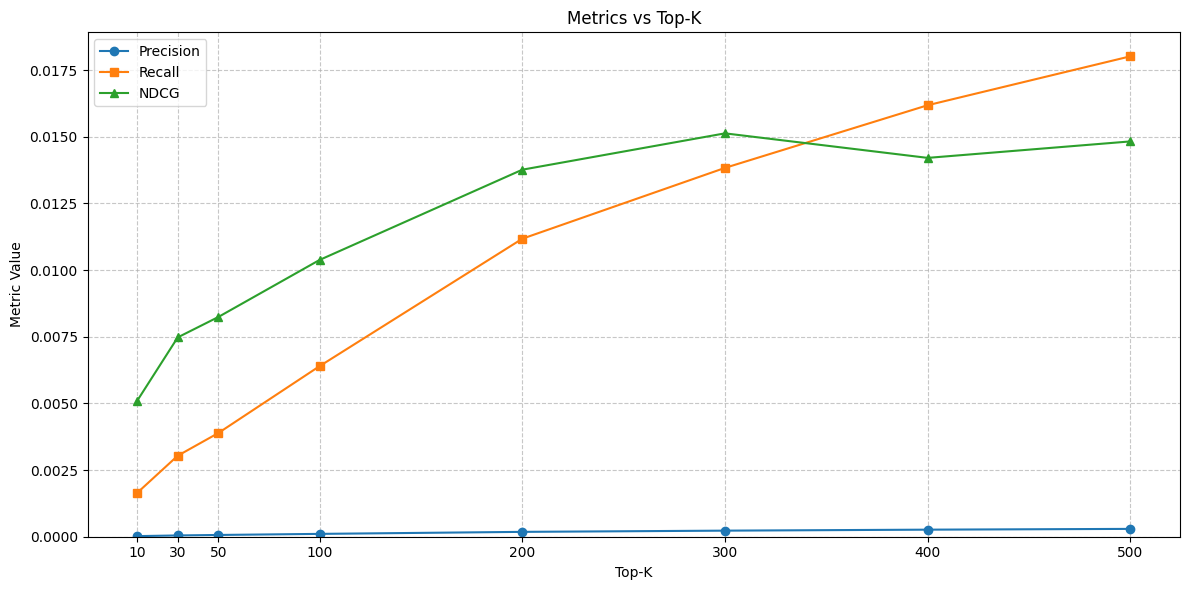

In [22]:
plt.figure(figsize=(12, 6))

plt.plot(topk_values, precisions, marker='o', label='Precision')

plt.plot(topk_values, recalls, marker='s', label='Recall')

plt.plot(topk_values, ndcgs, marker='^', label='NDCG')

plt.title('Metrics vs Top-K')
plt.xlabel('Top-K')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.xticks(topk_values)

plt.ylim(bottom=0)

plt.tight_layout()
plt.show()

In [30]:
import random

random_user_id = random.choice(list(recommendations_dict.keys()))
print(random_user_id)

train_df[train_df['user_id'] == random_user_id]

538197003


,event_type,product_id,category_id,category_code,brand,user_id,user_index,product_index,brand_index,category_index
13871865,view,3601437,2053013563810775923,appliances.kitchen.washer,lg,538197003,131935,147,40,28
13872751,view,3601489,2053013563810775923,appliances.kitchen.washer,samsung,538197003,131935,145,11,28
13873419,view,3601489,2053013563810775923,appliances.kitchen.washer,samsung,538197003,131935,145,11,28
13873847,view,3601505,2053013563810775923,appliances.kitchen.washer,samsung,538197003,131935,252,11,28
15198092,view,3601437,2053013563810775923,appliances.kitchen.washer,lg,538197003,131935,147,40,28
15199034,view,3601402,2053013563810775923,appliances.kitchen.washer,lg,538197003,131935,1162,40,28
15203799,view,3601515,2053013563810775923,appliances.kitchen.washer,samsung,538197003,131935,1148,11,28
15204267,view,3600835,2053013563810775923,appliances.kitchen.washer,samsung,538197003,131935,2235,11,28
15205072,view,3600999,2053013563810775923,appliances.kitchen.washer,samsung,538197003,131935,1991,11,28
15205232,view,3601486,2053013563810775923,appliances.kitchen.washer,lg,538197003,131935,3966,40,28


In [31]:
recommend_product_ids = recommendations_dict[random_user_id]
recommend_product_dict = train_df[train_df['product_id'].isin(recommend_product_ids)].groupby('product_id').apply(
    lambda x: tuple(x[['category_code', 'brand']].iloc[0])
).to_dict()

for product_id in recommend_product_ids[:20]:
    category_code, brand = recommend_product_dict[product_id]
    print(category_code, brand)

electronics.smartphone #unknown
electronics.smartphone huawei
electronics.smartphone #unknown
#unknown #unknown
#unknown #unknown
electronics.smartphone texet
electronics.smartphone honor
electronics.smartphone apple
electronics.smartphone huawei
furniture.bedroom.bed #unknown
electronics.smartphone gionee
electronics.smartphone samsung
electronics.smartphone apple
electronics.smartphone samsung
electronics.smartphone xiaomi
electronics.smartphone doogee
electronics.smartphone bq
electronics.smartphone nokia
electronics.smartphone samsung
#unknown vega


/var/folders/61/z_y23ln573b2r1g8y664sldc0000gn/T/ipykernel_83875/3293158499.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  recommend_product_dict = train_df[train_df['product_id'].isin(recommend_product_ids)].groupby('product_id').apply(
